In [52]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## Retrieve dataset

In [6]:
df = pd.read_csv('../input/spy.csv')

# Verify if no nan or inf values
print(df.isna().sum())
print(np.isinf(df[['Close', 'Volume', 'Weekday']]).sum())

df

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
Day        0
Weekday    0
Week       0
Month      0
Year       0
dtype: int64
Close      0
Volume     0
Weekday    0
dtype: int64


,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
0,1993-01-29,24.543517,24.543517,24.421410,24.526073,1003200,29,4,4,1,1993
1,1993-02-01,24.543515,24.700510,24.543515,24.700510,480500,1,0,5,2,1993
2,1993-02-02,24.683072,24.770292,24.630741,24.752848,201300,2,1,5,2,1993
3,1993-02-03,24.787724,25.031938,24.770280,25.014494,529400,3,2,5,2,1993
4,1993-02-04,25.101718,25.171493,24.822616,25.119162,531500,4,3,5,2,1993
...,...,...,...,...,...,...,...,...,...,...,...
8072,2025-02-24,602.020020,603.030029,596.489990,597.210022,50737200,24,0,9,2,2025
8073,2025-02-25,597.150024,597.890015,589.559998,594.239990,58266500,25,1,9,2,2025
8074,2025-02-26,595.929993,599.580017,591.859985,594.539978,43321600,26,2,9,2,2025
8075,2025-02-27,596.849976,598.020020,584.650024,585.049988,74196700,27,3,9,2,2025


## Visualization

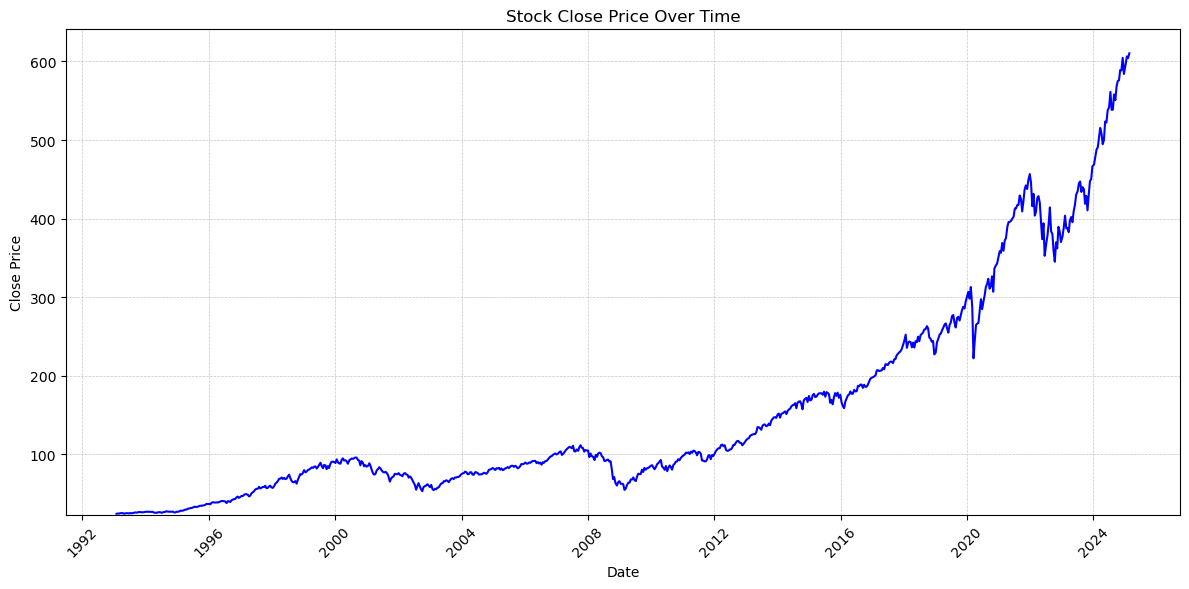

In [7]:
df = df.copy()

# Convert 'Date' to datetime 
df['Date'] = pd.to_datetime(df['Date'])

# Sample the data to reduce the number of points for plotting
df_sampled = df.iloc[::10].copy()

def stocks_plot(df, start_date=None, end_date=None, format='%Y'):
    """
    Plots the closing price of stocks over time with optional date filtering and formatting.
    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing stock data. Must include 'Date' and 'Close' columns.
    start_date : str or None, optional
        The start date for filtering the data in 'YYYY-MM-DD' format. Defaults to None.
    end_date : str or None, optional
        The end date for filtering the data in 'YYYY-MM-DD' format. Defaults to None.
    format : str, optional
        The date format for the x-axis labels. Defaults to '%Y'.
    """

    df_filtered = df.copy()

    # Filter the DataFrame based on the provided start and end dates
    if start_date:
        df_filtered = df_filtered[df_filtered['Date'] >= start_date]
    if end_date:
        df_filtered = df_filtered[df_filtered['Date'] <= end_date]

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered['Date'], df_filtered['Close'], label='Close Price', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Stock Close Price Over Time')

    # Format the x-axis to show dates
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(format)) 
    plt.xticks(rotation=45)

    # Set the x-axis and y-axis limits based on date limits and filtered data
    plt.xlim(start_date, end_date)
    plt.ylim(df_filtered['Close'].min() * 0.95, df_filtered['Close'].max() * 1.05)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

stocks_plot(df_sampled)
plt.show()

## Linear stationnary processes

In [ ]:
# TODO : check mean and std (kaggle)
# TODO : check rolling means

### Differencing

In order to make process stationary (ARIMA model) and eliminate trends eg. continuous rises, etc

In [ ]:
d = 3
Close_diff = df['Close'].copy()
for _ in range(d):
    Close_diff = Close_diff.diff().dropna()
Close_diff

12       1.046650
13      -0.610535
14       0.104631
15      -0.104624
16      -0.104689
          ...    
8072    15.600037
8073    -7.950073
8074     3.510071
8075   -13.059998
8076    28.409973
Name: Close, Length: 8065, dtype: float64

### Autocorrelation

- Measures the correlation between the time series and a lagged version of itself
- In order to be stationary, the decay should not be too slow but gradual. Indeed, each value is influenced by past values, but that influence fades with time. The system has a memory, but it's short-term (root less than 1).
- ACF shows seasonality
- For MA models, it should cut off after some lag q (depends only on last q noises)
- For AR models, it should decrease gradually (exponential decay)

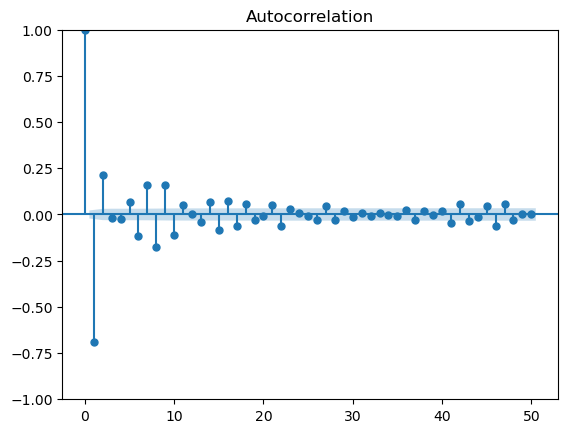

In [ ]:
plot_acf(Close_diff, lags=50)
plt.title('Autocorrelation')
plt.show()

### Partial autocorrelation 

- Measures the pure correlation between the series and a lagged version of itself, after removing the effect of intermediate lags.
- In the case of non-stationarity, the partial autocorrelation at lag 1 is trying to explain the whole drift. There’s no “direct” influence from further lags as it’s just noise.
- For AR models, it should cut off after some lag q (no more linear dependence)
- For MA models, it shoud decrease gradually (accumulated indirect effects)

/Users/lohenrotte/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


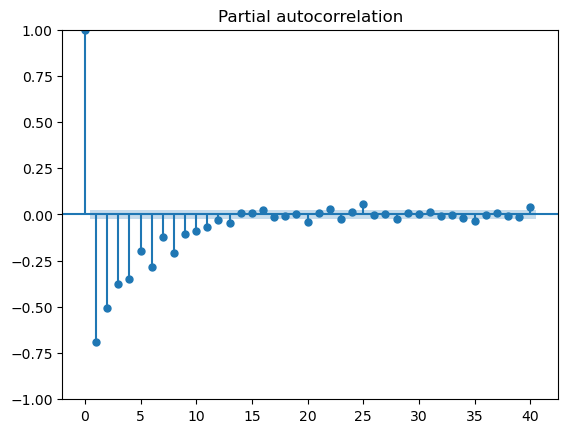

In [50]:
plot_pacf(Close_diff)
plt.title('Partial autocorrelation')
plt.show()

### ADF Test

The Augmented Dickey-Fuller test is a statistical test for stationarity in time series data. If p > 0.05 → non-stationary

In [51]:
result = adfuller(Close_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -32.176231581461124
p-value: 0.0


### ARIMA Model

In [55]:
# Values from ACF, PACF analysis
p = 13; q = 10

# Split train data
frac = 0.7
split_id = int(len(df) * frac)
df_train = df.iloc[:split_id].copy()

model = ARIMA(df_train["Close"], order=(p, d, q))
model_fit = model.fit()

/Users/lohenrotte/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lohenrotte/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lohenrotte/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lohenrotte/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/lohenrotte/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.

In [56]:
future_steps = 100
forecast = model_fit.forecast(steps=100)

/Users/lohenrotte/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


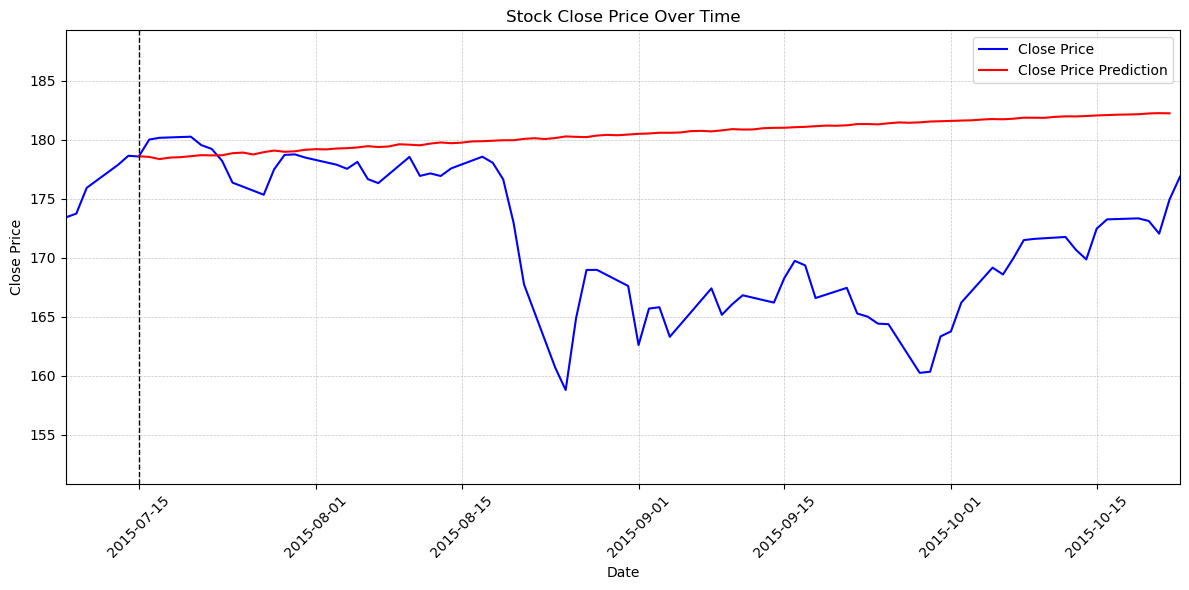

In [61]:
# Define date limits for plotting
start_date = df_train['Date'].iloc[-1] - pd.Timedelta(days=7)
end_date = df_train['Date'].iloc[-1] + pd.Timedelta(days = future_steps)

# Plot to compare predictions with actual values
stocks_plot(df, start_date, end_date, '%Y-%m-%d')

# Get associated dates
date_list = pd.date_range(start=df_train['Date'].iloc[-1], periods=future_steps, freq='D')

plt.plot(date_list, forecast, label='Close Price Prediction', color='red')
plt.axvline(df_train['Date'].iloc[-1], color='k', linestyle='--', linewidth=1)
plt.legend()
plt.show()

## Random forest

### Training

In [ ]:
# Create a sliding window of n days and generate lagged features
n = 10
window = [i for i in range(n)]
df= df.copy()      # Since view of df, better to create a copy
for i in window:
    df[f'Close_{i}'] = df['Close'].shift(i)
df.dropna(inplace=True)       # Handle NaN values from shifting

# Split the data into training and testing sets
# Future data for testing as it aligns with how the model will be used in real-world scenarios
frac = 0.7
split_id = int(len(df) * frac)
df_train = df.iloc[:split_id]
df_test = df.iloc[split_id:]

# Features of interest
features = [f'Close_{i}' for i in window]

In [9]:
# # Using RandomizedSearchCV for hyperparameter tuning
# search_model = RandomizedSearchCV(
#     estimator=RandomForestRegressor(),
#     param_distributions={
#         'n_estimators': [50, 100, 200, 500],
#         'max_depth': [10, 30, 50, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4]
#     },
#     cv=5,
#     verbose=2,
#     n_jobs=-1
# )
# search_model.fit(df_train[features], df_train['Close'])
# print(search_model.best_params_)

In [10]:
# Model with parameters found through RandomizedSearchCV
model = RandomForestRegressor(n_estimators=50, max_depth=30, min_samples_split=5, random_state=42)

# Train the model
model.fit(df_train[features], df_train['Close'])

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,Close_0,9.589280e-01
1,Close_1,1.703951e-02
29,Close_29,1.506742e-02
25,Close_25,4.926365e-03
2,Close_2,8.102110e-04
5,Close_5,5.734945e-04
6,Close_6,4.612099e-04
3,Close_3,4.072997e-04
4,Close_4,3.971812e-04
8,Close_8,2.321500e-04


### Forecasting

In [11]:
# List of Close values for the last n days before the first test set item
prev_list = [df_train['Close'].iloc[-i] for i in window]

y_pred = []

# Iterate through the test set 
for i in range(len(df_test)):
    input_data = pd.DataFrame([prev_list], columns=features)
    
    # Predict the next value
    current_pred = model.predict(input_data)[0]
    y_pred.append(current_pred)

    # Window is updated with the new predicted value
    prev_list = prev_list[1:] + [current_pred]

df_test = df_test.copy() 
df_test['Close_pred'] = y_pred

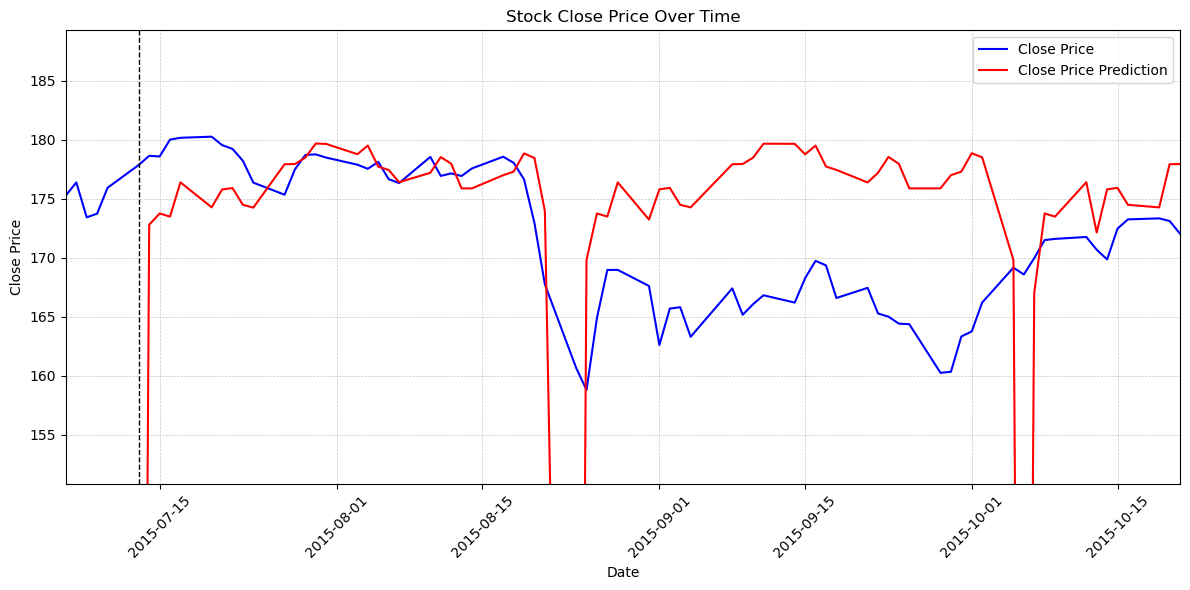

In [12]:
# Define date limits for plotting
start_date = df_test['Date'].iloc[0] - pd.Timedelta(days=7)
end_date = df_test['Date'].iloc[0] + pd.Timedelta(days=100)

# Plot to compare predictions with actual values
stocks_plot(df, start_date, end_date, '%Y-%m-%d')
plt.plot(df_test['Date'], df_test['Close_pred'], label='Close Price Prediction', color='red')
plt.axvline(df_test['Date'].iloc[0], color='k', linestyle='--', linewidth=1)
plt.legend()
plt.show()